In [1]:
import pandas as pd
import numpy as np
import zipfile
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import transforms
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Reproducibility Fix the random seed.
torch.manual_seed(12)
torch.cuda.manual_seed(12)
np.random.seed(12)
torch.backends.cudnn.deterministic=True
def seed_worker(worker_id):
    numpy.random.seed(12)
    random.seed(12)

g = torch.Generator()
g.manual_seed(0)

In [3]:
#Set the dataset file path
CONTENT_DIR = 'datasets'

TRAIN_DIR = CONTENT_DIR + '/train'
TRAIN_DIR_DOG = TRAIN_DIR + '/dog'
TRAIN_DIR_CAT = TRAIN_DIR + '/cat'

VALID_DIR = CONTENT_DIR + '/val'
VALID_DIR_DOG = VALID_DIR + '/dog'
VALID_DIR_CAT = VALID_DIR + '/cat'

TEST_DIR = CONTENT_DIR + '/test'

In [4]:
# Load file
dog_train_filenames = os.listdir(TRAIN_DIR_DOG)
dog_train_filenames_full=[TRAIN_DIR_DOG+'/'+dogs for dogs in dog_train_filenames]
dog_train_filenames_abs=[os.path.abspath(path) for path in dog_train_filenames_full]
cat_train_filenames=os.listdir(TRAIN_DIR_CAT)
cat_train_filenames_full=[TRAIN_DIR_CAT+'/'+cats for cats in cat_train_filenames]
cat_train_filenames_abs=[os.path.abspath(path) for path in cat_train_filenames_full]

dog_val_filenames = os.listdir(VALID_DIR_DOG)
dog_val_filenames_full=[VALID_DIR_DOG+'/'+dogs for dogs in dog_val_filenames]
dog_val_filenames_abs=[os.path.abspath(path) for path in dog_val_filenames_full]
cat_val_filenames=os.listdir(VALID_DIR_CAT)
cat_val_filenames_full=[VALID_DIR_CAT+'/'+cats for cats in cat_val_filenames]
cat_val_filenames_abs=[os.path.abspath(path) for path in cat_val_filenames_full]


test_filenames = os.listdir(TEST_DIR)
test_filenames_full=[TEST_DIR+'/'+dogs for dogs in test_filenames]

train_total=dog_train_filenames_abs+cat_train_filenames_abs
valid_total=dog_val_filenames_abs+cat_val_filenames_abs
test_total=[os.path.abspath(path) for path in test_filenames_full]

In [37]:
# Define the image preprocessing
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [38]:
#Define dataset
class cats_dogs_dataset(Dataset):
    def __init__(self,train_total,transforms=None):
        self.filename = train_total
        self.tf=transforms
    def __len__(self):
        return len(self.filename)

    def __getitem__(self, idx):
        file = self.filename[idx]
        tsr_img = Image.open(file)
        if self.tf:
            tsr_img=self.tf(tsr_img)
        labels = self.filename[idx].split('\\')
        if labels[-1].startswith("dog"):
            label=0
        else:
            label=1
        return tsr_img,label

In [40]:
#Create data loader
trainset=cats_dogs_dataset(train_total,data_transform)
valset=cats_dogs_dataset(valid_total,data_transform)
testset=cats_dogs_dataset(test_total,data_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,shuffle=True,worker_init_fn=seed_worker,generator=g)
valloader = torch.utils.data.DataLoader(valset, batch_size=128,shuffle=False,worker_init_fn=seed_worker,generator=g)
testloader=torch.utils.data.DataLoader(testset, batch_size=260,shuffle=False,worker_init_fn=seed_worker,generator=g)

In [41]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

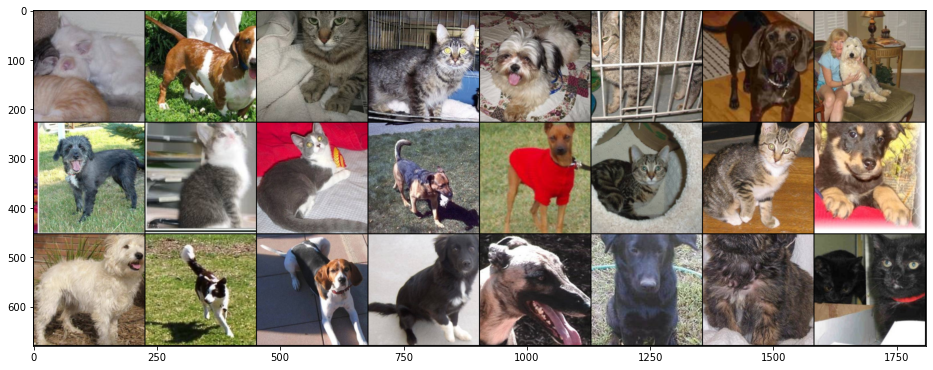

In [49]:
#Plot pictures to check
samples, labels = iter(testloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [19]:
net = AlexNet(2).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [20]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.cuda()
        labels=labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 0.693
[1,    20] loss: 0.693
[1,    30] loss: 0.693
[1,    40] loss: 0.693
[1,    50] loss: 0.693
[1,    60] loss: 0.693
[1,    70] loss: 0.692
[1,    80] loss: 0.692
[1,    90] loss: 0.692
[1,   100] loss: 0.691
[1,   110] loss: 0.691
[1,   120] loss: 0.689
[1,   130] loss: 0.689
[1,   140] loss: 0.687
[1,   150] loss: 0.688
[2,    10] loss: 0.676
[2,    20] loss: 0.666
[2,    30] loss: 0.669
[2,    40] loss: 0.663
[2,    50] loss: 0.663
[2,    60] loss: 0.652
[2,    70] loss: 0.644
[2,    80] loss: 0.637
[2,    90] loss: 0.623
[2,   100] loss: 0.656
[2,   110] loss: 0.661
[2,   120] loss: 0.655
[2,   130] loss: 0.635
[2,   140] loss: 0.630
[2,   150] loss: 0.650
[3,    10] loss: 0.623
[3,    20] loss: 0.619
[3,    30] loss: 0.626
[3,    40] loss: 0.637
[3,    50] loss: 0.625
[3,    60] loss: 0.617
[3,    70] loss: 0.606
[3,    80] loss: 0.616
[3,    90] loss: 0.610
[3,   100] loss: 0.595
[3,   110] loss: 0.603
[3,   120] loss: 0.593
[3,   130] loss: 0.584
[3,   140] 

In [22]:
torch.save(net.state_dict(), "Alex_with_p.pth")

In [24]:
#Test model on valset
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        images=images.cuda()
        labels=labels.cuda()
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 91 %


In [48]:
#Write the prediction to testset into csv file
import csv
mapback=[1,0]
i=0
with open('result1.csv', 'w', newline="") as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    with torch.no_grad():
        for data in testloader:
            images1, labels1 = data
            images1=images1.cuda()
            labels1=labels1.cuda()
            # calculate outputs by running images through the network
            outputs1 = net(images1)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs1.data, 1)
            for word in predicted:
                wr.writerow([int(test_filenames[i].replace(".jpg","")),mapback[word.item()]])
                i+=1
        